## 14. 비정형 데이터 실습

### 14.1. 이미지 분류

In [2]:
using MLDatasets: MNIST
# 필요 데이터 자동 다운로드
ENV["DATADEPS_ALWAYS_ACCEPT"] = true
trainset = MNIST(:train)
testset = MNIST(:test)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

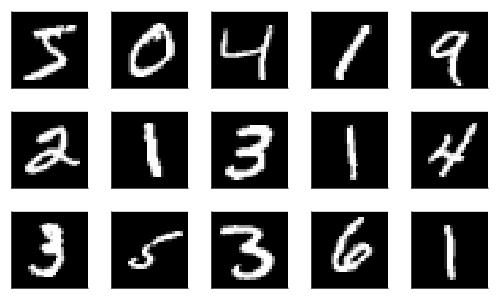

In [4]:
using MLDatasets: convert2image
using Plots, ImageShow
gr(size=(500,300))
imgs = [heatmap(convert2image(trainset, i), ticks=[]) for i in 1:15]
plot(imgs..., layout=(3,5))

데이터 정형화

In [5]:
using DataFrames, MLJ
img_size = prod(size(trainset.features)[1:2]); # 28 * 28
train_flat = reshape(trainset.features, img_size, :);
X_train = DataFrame(transpose(train_flat), :auto);
y_train = coerce(trainset.targets, Multiclass);
test_flat = reshape(testset.features, img_size, :);
X_test = DataFrame(transpose(test_flat), :auto);
y_test = coerce(testset.targets, Multiclass);

다양한 모델 적용

In [6]:
Logistic = @load LogisticClassifier pkg=MLJLinearModels verbosity=0;
solver = MLJLinearModels.ProxGrad(accel=true, tol=0.01);
model = Logistic(penalty=:l1, lambda=0.0, solver=solver);
mach = machine(model, X_train, y_train);
@time fit!(mach, verbosity=0);
accuracy(predict_mode(mach, X_test), y_test)

 43.973423 seconds (29.34 M allocations: 47.778 GiB, 3.04% gc time, 8.73% compilation time)


0.9203

In [8]:
PCA = @load PCA pkg=MultivariateStats verbosity=0;
model = PCA(variance_ratio=0.98) |> 
    Logistic(penalty=:l1, lambda=0.0, solver=solver);
mach = machine(model, X_train, y_train);
@time fit!(mach, verbosity=0);
accuracy(predict_mode(mach, X_test), y_test) 

 21.679196 seconds (31.65 M allocations: 19.325 GiB, 3.41% gc time, 24.39% compilation time)


0.9247

In [9]:
report(mach).pca

(indim = 784,
 outdim = 261,
 tprincipalvar = 51.678707f0,
 tresidualvar = 1.0472069f0,
 tvar = 52.725914f0,
 mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.00078601314, 0.00034849675, 0.00017895426, 7.562091f-5, 5.9281047f-5, 7.843138f-6, 0.0, 0.0, 0.0, 0.0],
 principalvars = Float32[5.116875, 3.7413912, 3.2527087, 2.8416212, 2.5671182, 2.2736633, 1.725155, 1.5205601, 1.456305, 1.2427503  …  0.009969277, 0.009913146, 0.009827699, 0.009798969, 0.009734153, 0.009685499, 0.009656566, 0.009589813, 0.009483593, 0.009361844],
 loadings = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],)

In [10]:
model = PCA(maxoutdim=40) |> 
    InteractionTransformer(order=2) |> 
    Logistic(penalty=:l1, lambda=0.0, solver=solver);
mach = machine(model, X_train, y_train);
@time fit!(mach, verbosity=0);
accuracy(predict_mode(mach, X_test), y_test)

 50.968562 seconds (19.57 M allocations: 52.392 GiB, 2.17% gc time, 11.10% compilation time)


0.9784

In [14]:
KNN = @load KNNClassifier pkg=NearestNeighborModels verbosity=0;
SVM = @load SVC pkg=LIBSVM verbosity=0;
XGB = @load XGBoostClassifier pkg=XGBoost verbosity=0;
LGBM = @load LGBMClassifier pkg=LightGBM verbosity=0;

logistic = Logistic(penalty=:l1, lambda=0.0, solver=solver);
knn = KNN(); # K = 5
svm = SVM(); # kernel = RadialBasis
xgb = XGB(); # num_round = 100
lgbm = LGBM(num_iterations=100);

In [15]:
function get_model(ty, clf)
    ty == 1 ? clf :
    ty == 2 ? (PCA(variance_ratio=0.98) |> clf) :
    (PCA(maxoutdim=40) |> InteractionTransformer(order=2) |> clf)
end

function run_batch(ty, clfs, X_tr, y_tr, X_te, y_te)
    res = []
    for clf in clfs
        model = get_model(ty, clf)
        mach = machine(model, X_tr, y_tr)
        fit_t = @elapsed fit!(mach, verbosity=0)
        is_proba = prediction_type(clf) == :probabilistic
        oper = is_proba ? predict_mode : predict
        pred_t = @elapsed pred = oper(mach, X_te)
        acc = accuracy(pred, y_te)
        stats = (fit_t, pred_t, acc)
        r = clf => round.(stats, digits=4)
        println(r)
        push!(res, r)
    end
    res
end

run_batch (generic function with 1 method)

In [16]:
clfs = [logistic, knn, svm, xgb, lgbm];
res1 = run_batch(1, clfs, X_train, y_train, X_test, y_test);
res2 = run_batch(2, clfs, X_train, y_train, X_test, y_test);
res3 = run_batch(3, clfs, X_train, y_train, X_test, y_test);
res = vcat(res1, res2, res3)

LogisticClassifier(lambda = 0.0, …) => (40.321, 0.2234, 0.9203)
KNNClassifier(K = 5, …) => (6.5304, 86.7641, 0.9688)
SVC(kernel = RadialBasis, …) => (245.0422, 65.1282, 0.9793)
XGBoostClassifier(test = 1, …) => (678.7941, 1.05, 0.9795)
LGBMClassifier(boosting = gbdt, …) => (47.2049, 0.7846, 0.9774)
LogisticClassifier(lambda = 0.0, …) => (15.9963, 0.2335, 0.9247)
KNNClassifier(K = 5, …) => (2.2072, 18.891, 0.9694)
SVC(kernel = RadialBasis, …) => (111.1661, 21.4243, 0.9829)
XGBoostClassifier(test = 1, …) => (1133.934, 0.3588, 0.9641)
LGBMClassifier(boosting = gbdt, …) => (46.4897, 0.9079, 0.9636)
LogisticClassifier(lambda = 0.0, …) => (48.6717, 0.2528, 0.9784)
KNNClassifier(K = 5, …) => (8.4381, 88.3762, 0.9735)
SVC(kernel = RadialBasis, …) => (442.4705, 80.7902, 0.9844)
XGBoostClassifier(test = 1, …) => (3445.3531, 0.3878, 0.9699)
LGBMClassifier(boosting = gbdt, …) => (153.4908, 0.9436, 0.9683)


15-element Vector{Any}:
 LogisticClassifier(lambda = 0.0, …) => (40.321, 0.2234, 0.9203)
             KNNClassifier(K = 5, …) => (6.5304, 86.7641, 0.9688)
        SVC(kernel = RadialBasis, …) => (245.0422, 65.1282, 0.9793)
      XGBoostClassifier(test = 1, …) => (678.7941, 1.05, 0.9795)
  LGBMClassifier(boosting = gbdt, …) => (47.2049, 0.7846, 0.9774)
 LogisticClassifier(lambda = 0.0, …) => (15.9963, 0.2335, 0.9247)
             KNNClassifier(K = 5, …) => (2.2072, 18.891, 0.9694)
        SVC(kernel = RadialBasis, …) => (111.1661, 21.4243, 0.9829)
      XGBoostClassifier(test = 1, …) => (1133.934, 0.3588, 0.9641)
  LGBMClassifier(boosting = gbdt, …) => (46.4897, 0.9079, 0.9636)
 LogisticClassifier(lambda = 0.0, …) => (48.6717, 0.2528, 0.9784)
             KNNClassifier(K = 5, …) => (8.4381, 88.3762, 0.9735)
        SVC(kernel = RadialBasis, …) => (442.4705, 80.7902, 0.9844)
      XGBoostClassifier(test = 1, …) => (3445.3531, 0.3878, 0.9699)
  LGBMClassifier(boosting = gbdt, …) => (153.4

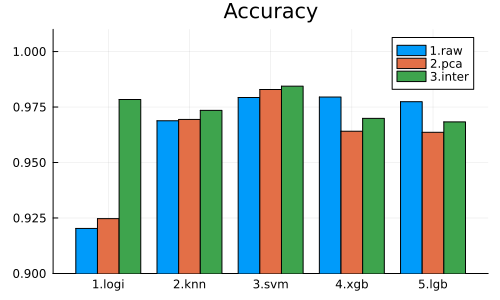

In [20]:
using StatsPlots
gr(size=(500,300))
clfnms = ["1.logi", "2.knn", "3.svm", "4.xgb", "5.lgb"];
group = repeat(["1.raw", "2.pca", "3.inter"], inner=5);
x = repeat(clfnms, outer=3);
y = transpose(reduce(hcat, collect.(last.(res))))
groupedbar(x, y[:,3], group=group, ylim=[0.9,1.01], title="Accuracy")

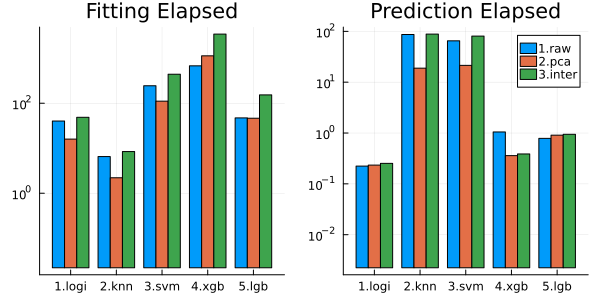

In [21]:
gr(size=(600,300))
p1 = groupedbar(x, y[:,1], group=group, yaxis=:log);
plot!(p1, legend=nothing, title="Fitting Elapsed");
p2 = groupedbar(x, y[:,2], group=group, yaxis=:log);
plot!(p2, title="Prediction Elapsed");
plot(p1, p2, layout=(1,2))